In [2]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [3]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "Adipose_Adipose_HCLAdultAdipose1"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.txt.gz"),h = T,sep=',',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}

In [4]:
# Load the metadata and annotation
# data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 6)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.csv"), h = T, sep = ",", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

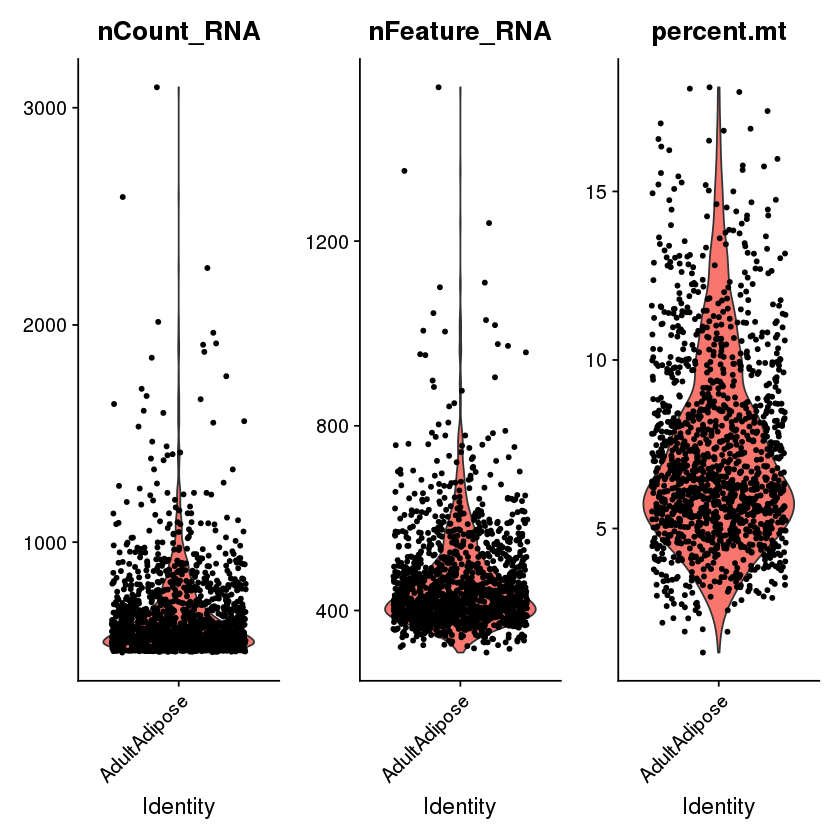

In [5]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [6]:
percent.mt.thre = 20
nFeature_RNA_range = c(min.features, 1000)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [7]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [9]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 12154  1362
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A2M"    "A4GALT" "AAAS"   "AACS"   "AADAC" 
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 11386  1362
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  1362
[1] "Finished"


In [10]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.annotation)
# dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Warning message in CreateSeuratObject(result_data_out, meta.data = data.annotation):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  DCN, GPX3, APOD, PLA2G2A, MGP, IFITM3, MGST1, ADH1B, NNMT, SERPING1 
	   MT2A, MFAP5, C1R, COL6A3, MT1X, COL1A2, C1S, C3, COL4A1, FSTL1 
	   MT1M, SERPINF1, CFD, COL3A1, MT1E, CXCL14, LUM, COL6A1, NID1, EFEMP1 
Negative:  CTSB, C1QA, C1QB, CD163, HLA-B, HSPA1A, NPC2, CD74, C1QC, F13A1 
	   HSPA1B, SRGN, VSIG4, LYVE1, CTSD, MS4A6A, CREG1, MRC1, DNAJB1, STAB1 
	   CXCL8, HLA-DRA, KLF6, LGMN, LAPTM5, HSP90AA1, MAFB, CD68, A2M, CTSS 
PC_ 2 
Positive:  FABP4, LPL, FABP5P1, MMP9, SH3BGRL3, TREM2, CD36, SLC39A8, MMP7, SCGB1D1 
	   CSTB, APOC1, CD52, FBP1, S100A11, CHI3L1, SERF2, LGALS1, ARPC2, G0S2 
	   MMP19, ITGB2, RAC2, ANXA2, GAPDH, APOE, TSC22D1, CFL1, RGS1, RAB7B 
Negative:  EGR1, JUN, NR4A1, HSPA1A, JUNB, TNFAIP2, KLF4, JUND, F13A1, IER2 
	   CXCL8, PDK4, MMP2, CCL4, MCL1, THBS1, STAB1, KLF2, FSTL1, DCN 
	   LYVE1, NEAT1, CXCL12, KLF6, C1R, C3, PNRC1, DNAJB1, C1QA, HSPA1B 
PC_ 3 
Positive:  LPL, CD36, MMP7, FABP4, MMP9, GSN, TREM2, FABP5P1, CTSB, SCGB1D1 
	   MMP2, SL

png 
  2

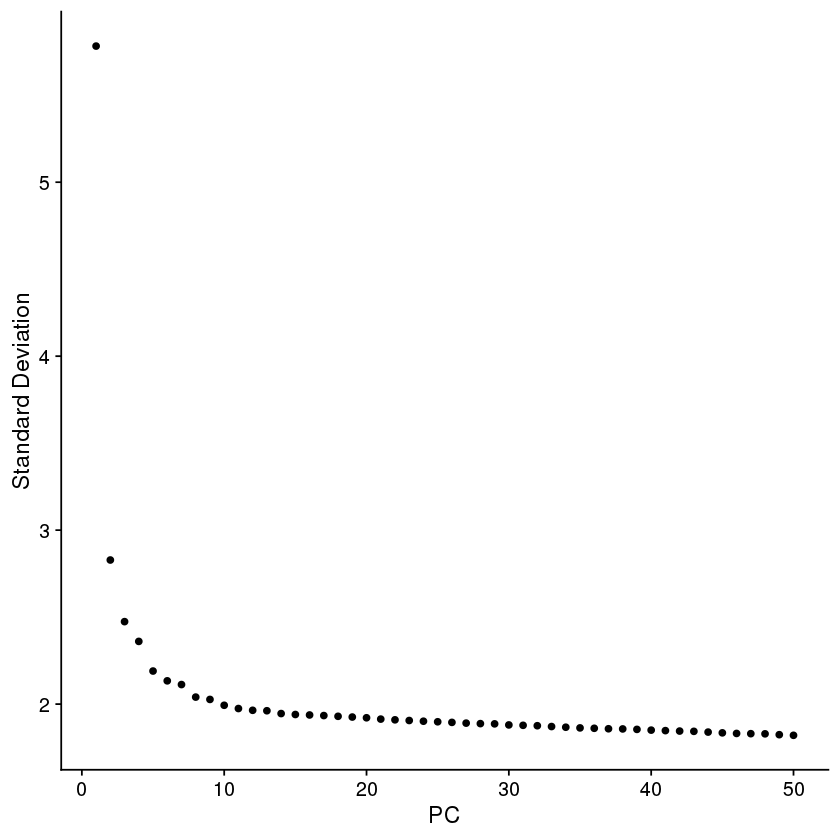

In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [12]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [13]:
dataobj$cell_cluster <- dataobj$CT

In [14]:
dataobj <- FindClusters(dataobj, resolution = 0.7, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1362
Number of edges: 97482

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.6534
Number of communities: 4
Elapsed time: 0 seconds


ARI 
0.7256399

In [15]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:30:24 UMAP embedding parameters a = 0.9922 b = 1.112

10:30:24 Read 1362 rows and found 30 numeric columns

10:30:24 Using Annoy for neighbor search, n_neighbors = 30

10:30:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:30:25 Writing NN index file to temp file /tmp/RtmpwPDZ14/file20c82a61098a

10:30:25 Searching Annoy index using 1 thread, search_k = 3000

10:30:26 Annoy recall = 100%

10:30:26 Commencing smooth kNN distance calibration using 1 thread

10:30:27 Initializing fr

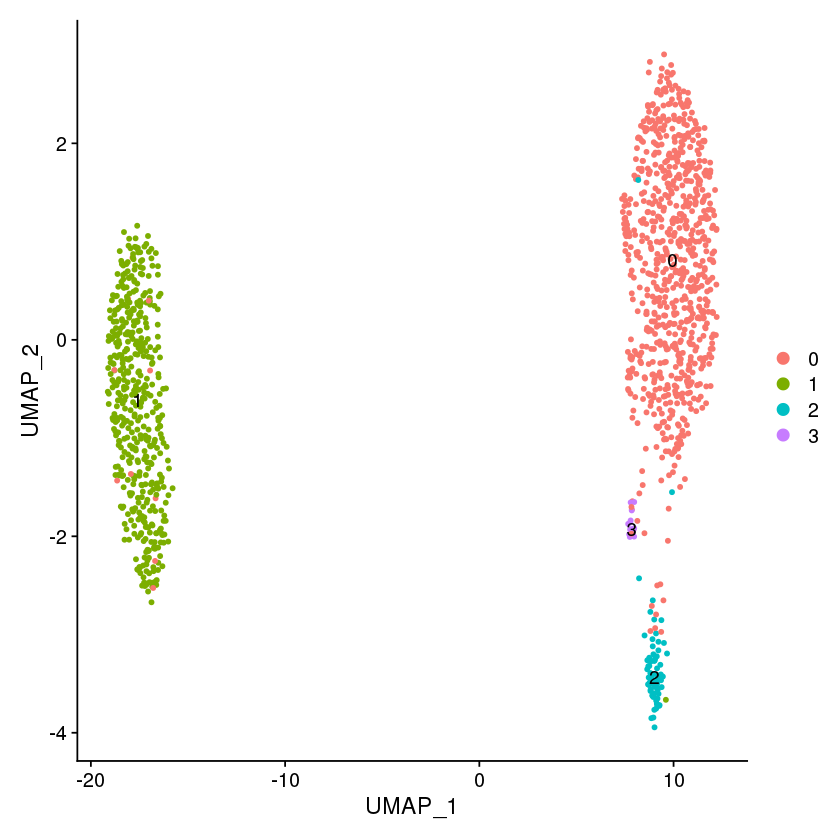

In [24]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

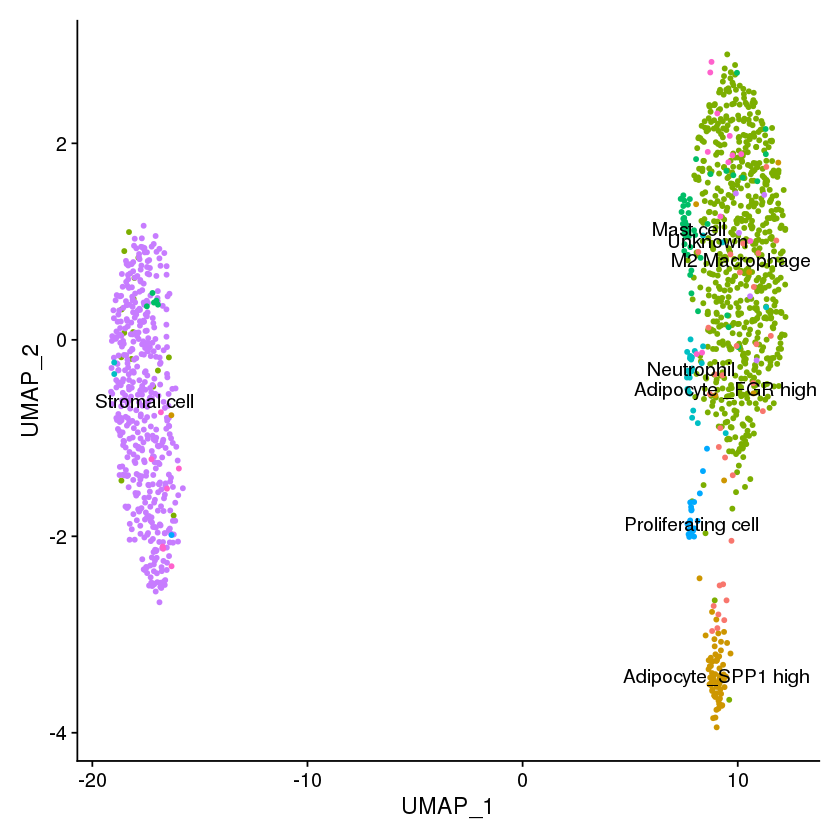

In [25]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [21]:
new.cluster.ids <- c("Adipose-Connective tissue-Macrophage-C1QA", 
                     "Adipose-Connective tissue-Fibroblast-DCN",
                     "Adipose-Connective tissue-Adipocyte-FABP4",
                     "Unclassified"
                    )

In [20]:
subset(dataobj.markers,cluster=='3')
# subset(dataobj.markers,gene=='NUPR1')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
KIFC1,6.565017e-100,1.957916,0.333,0.000,2.880598e-95,3,KIFC1
UBE2C,1.012449e-74,2.208976,0.467,0.004,4.442425e-70,3,UBE2C
TOP2A,3.992081e-67,2.364789,0.533,0.008,1.751645e-62,3,TOP2A
CCNB1,3.314603e-65,2.109638,0.400,0.004,1.454381e-60,3,CCNB1
BIRC5,3.571524e-64,1.539110,0.267,0.001,1.567113e-59,3,BIRC5
FOXM1,1.344162e-60,1.411627,0.200,0.000,5.897914e-56,3,FOXM1
CEP55,1.575640e-53,1.646498,0.267,0.001,6.913593e-49,3,CEP55
KIF11,4.046171e-46,1.797448,0.267,0.002,1.775379e-41,3,KIF11
KIF14,1.547933e-45,1.323088,0.200,0.001,6.792022e-41,3,KIF14


In [22]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [23]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

10:54:12 UMAP embedding parameters a = 0.9922 b = 1.112

10:54:12 Read 1362 rows and found 30 numeric columns

10:54:12 Using Annoy for neighbor search, n_neighbors = 30

10:54:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:54:13 Writing NN index file to temp file /tmp/RtmpwPDZ14/file20c855fbd898

10:54:13 Searching Annoy index using 1 thread, search_k = 3000

10:54:14 Annoy recall = 100%

10:54:14 Commencing smooth kNN distance calibration using 1 thread

10:54:15 Initializing from normalized Laplacian + noise

10:54:15 Commencing optimization for 500 epochs, with 57880 positive edges

10:54:20 Optimization finished



In [ ]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [25]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [30]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(dataobj$seurat_clusters),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [26]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [27]:
dataobj$donor_age    <- '36yr'
dataobj$donor_ID <- 'Adipose1'
dataobj$donor_gender <- "Male"

In [28]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Adipose"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-"NA"
dataobj.dbupload_v1$donor_gender<-"Male"
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [29]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)
dataobj.dbupload_v1$donor_age<- sub("Y","yr",dataobj.dbupload_v1$donor_age)


In [5]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [31]:
ncol(dataobj.dbupload_v1@meta.data)
colnames(dataobj.dbupload_v1@meta.data)

[1] 14

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subregion"     "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [33]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subregion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AdultAdipose_1.TATGTAACACCCGCAGGA,1,10.1038/s41586-020-2157-4,AdultAdipose_1.TATGTAACACCCGCAGGA,Adipose,NA,NA,Microwell-seq,Healthy,NA,Male,36yr,M2 Macrophage,NA,Adipose-Connective tissue-Macrophage-KNG1
AdultAdipose_1.CGAGTATCGTAATACTTC,1,10.1038/s41586-020-2157-4,AdultAdipose_1.CGAGTATCGTAATACTTC,Adipose,NA,NA,Microwell-seq,Healthy,NA,Male,36yr,M2 Macrophage,NA,Adipose-Connective tissue-Fibroblast-DCN
AdultAdipose_1.CTCGCAGCGAATCGGCAG,1,10.1038/s41586-020-2157-4,AdultAdipose_1.CTCGCAGCGAATCGGCAG,Adipose,NA,NA,Microwell-seq,Healthy,NA,Male,36yr,M2 Macrophage,NA,Adipose-Connective tissue-Macrophage-KNG1


In [4]:
dataobj.dbupload_v1 <- readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))